In [69]:
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import numpy as np
import torch.optim as optim
import time
import torch.nn.functional as F
import torchvision.models as models
from torchvision import datasets, transforms
from matplotlib import pyplot as plt

In [2]:
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
device

device(type='mps')

## Load Data

In [4]:
image_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.20, contrast=0.2),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [5]:
dataset_path = './dataset'
dataset = datasets.ImageFolder(root=dataset_path, transform=image_transform)
len(dataset)

2300

In [111]:
class_names = dataset.classes
class_names

['F_Breakage', 'F_Crushed', 'F_Normal', 'R_Breakage', 'R_Crushed', 'R_Normal']

In [7]:
num_classes = len(dataset.classes)
num_classes

6

In [8]:
train_size = int(0.75*len(dataset))
test_size = len(dataset) - train_size
train_size, test_size

(1725, 575)

In [9]:
from torch.utils.data import random_split

train_dataset, val_dataset = random_split(dataset, [train_size, test_size])

In [10]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [11]:
for image, labels in train_loader:
    print(image.shape)
    print(labels.shape)
    break

torch.Size([32, 3, 224, 224])
torch.Size([32])


In [12]:
image[0].shape

torch.Size([3, 224, 224])

In [13]:
image[0].permute(1,2,0).shape

torch.Size([224, 224, 3])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7754089..1.5071026].


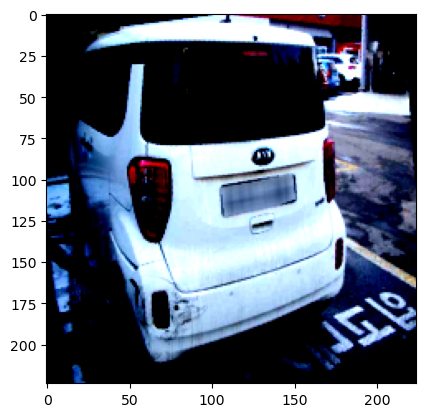

In [14]:
plt.imshow(image[0].permute(1,2,0)) #imshow expects 224x224,3 dimension thats why we did permute to show
plt.show()

## Model 1 Training

In [16]:
class CarClassifierCnn(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1, stride=1), # (16, 224, 224) output since padding is 1 so retaining original size of image
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), # (16, 112, 112)
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),  # (32, 56, 56)
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),# (64,28, 28)
            nn.Flatten(),
            nn.Linear(64*28*28, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes)
        )
    def forward(self, x):
        x = self.network(x)
        return x        
        

In [38]:
model = CarClassifierCnn(num_classes=num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
model.to(device)

CarClassifierCnn(
  (network): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Flatten(start_dim=1, end_dim=-1)
    (10): Linear(in_features=50176, out_features=512, bias=True)
    (11): ReLU()
    (12): Linear(in_features=512, out_features=6, bias=True)
  )
)

In [54]:
def train_model(model, criterion, optimizer, epochs):
    start = time.time()
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for batch_no, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            
            ##Forward pass 
            output = model(images)
            loss = criterion(output, labels)
            
            #backward
            loss.backward()
            
            #update weghts
            optimizer.step()
            if (batch_no+1) % 10 == 0:
                print(f"Batch: {batch_no+1}, Epoch {epoch}, Loss : {loss.item():.2f}")
                

            running_loss += loss.item() * images.size(0)
            
        epoch_loss = running_loss / len(train_loader.dataset)
        print(f"Epoch [{(epoch + 1)}/ {epochs}], Avg loss : {epoch_loss:.4f}")

        #Validation
        model.eval()
        correct = 0
        total = 0
        all_labels = []
        all_predicted = []
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                output = model(images)
                _ , predicted = torch.max(output.data, 1)
                total += labels.size(0)
                correct += (predicted==labels).sum().item()
                all_labels.extend(labels.cpu().numpy())
                all_predicted.extend(predicted.cpu().numpy())
            print(f"****** Validation Accuracy*** {correct * 100/total:.2f} %")

    end = time.time()
    print(f"Total time taken : {end - start} seconds")
    return all_labels, all_predicted
            
            

In [60]:
all_labels, all_predicted = train_model(model, criterion, optimizer, epochs=5)

Batch: 10, Epoch 0, Loss : 0.88
Batch: 20, Epoch 0, Loss : 0.97
Batch: 30, Epoch 0, Loss : 1.05
Batch: 40, Epoch 0, Loss : 1.11
Batch: 50, Epoch 0, Loss : 0.94
Epoch [1/ 5], Avg loss : 1.0748
****** Validation Accuracy*** 56.17 %
Batch: 10, Epoch 1, Loss : 1.07
Batch: 20, Epoch 1, Loss : 1.18
Batch: 30, Epoch 1, Loss : 0.75
Batch: 40, Epoch 1, Loss : 0.97
Batch: 50, Epoch 1, Loss : 1.06
Epoch [2/ 5], Avg loss : 0.9735
****** Validation Accuracy*** 56.70 %
Batch: 10, Epoch 2, Loss : 1.05
Batch: 20, Epoch 2, Loss : 1.05
Batch: 30, Epoch 2, Loss : 0.89
Batch: 40, Epoch 2, Loss : 0.91
Batch: 50, Epoch 2, Loss : 1.06
Epoch [3/ 5], Avg loss : 0.9260
****** Validation Accuracy*** 56.35 %
Batch: 10, Epoch 3, Loss : 0.96
Batch: 20, Epoch 3, Loss : 1.06
Batch: 30, Epoch 3, Loss : 0.94
Batch: 40, Epoch 3, Loss : 1.00
Batch: 50, Epoch 3, Loss : 0.87
Epoch [4/ 5], Avg loss : 0.8537
****** Validation Accuracy*** 57.39 %
Batch: 10, Epoch 4, Loss : 0.93
Batch: 20, Epoch 4, Loss : 1.02
Batch: 30, Epoch

## Model 1 Training with regularization

In [63]:
class CarClassifierCnnReguralization(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1, stride=1), # (16, 224, 224) output since padding is 1 so retaining original size of image
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), # (16, 112, 112)
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),  # (32, 56, 56)
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),# (64,28, 28)
            nn.Flatten(),
            nn.Linear(64*28*28, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )
    def forward(self, x):
        x = self.network(x)
        return x        
        

In [65]:
model = CarClassifierCnnReguralization(num_classes=num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
model.to(device)

CarClassifierCnnReguralization(
  (network): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Flatten(start_dim=1, end_dim=-1)
    (13): Linear(in_features=50176, out_features=512, bias=True)
    (14): ReLU()
    (15): Dropout(p=0.5, 

In [67]:
all_labels, all_predicted = train_model(model, criterion, optimizer, epochs=5)

Batch: 10, Epoch 0, Loss : 24.62
Batch: 20, Epoch 0, Loss : 5.28
Batch: 30, Epoch 0, Loss : 2.12
Batch: 40, Epoch 0, Loss : 1.65
Batch: 50, Epoch 0, Loss : 1.50
Epoch [1/ 5], Avg loss : 7.9096
****** Validation Accuracy*** 42.78 %
Batch: 10, Epoch 1, Loss : 1.55
Batch: 20, Epoch 1, Loss : 1.19
Batch: 30, Epoch 1, Loss : 1.22
Batch: 40, Epoch 1, Loss : 1.22
Batch: 50, Epoch 1, Loss : 1.18
Epoch [2/ 5], Avg loss : 1.3216
****** Validation Accuracy*** 51.48 %
Batch: 10, Epoch 2, Loss : 1.33
Batch: 20, Epoch 2, Loss : 1.08
Batch: 30, Epoch 2, Loss : 1.20
Batch: 40, Epoch 2, Loss : 1.14
Batch: 50, Epoch 2, Loss : 1.19
Epoch [3/ 5], Avg loss : 1.2274
****** Validation Accuracy*** 51.48 %
Batch: 10, Epoch 3, Loss : 1.19
Batch: 20, Epoch 3, Loss : 1.27
Batch: 30, Epoch 3, Loss : 0.85
Batch: 40, Epoch 3, Loss : 1.11
Batch: 50, Epoch 3, Loss : 1.32
Epoch [4/ 5], Avg loss : 1.1893
****** Validation Accuracy*** 49.91 %
Batch: 10, Epoch 4, Loss : 1.14
Batch: 20, Epoch 4, Loss : 1.31
Batch: 30, Epoc

## Model 3 using transfer learning with EfficientNet

In [71]:
model = models.efficientnet_b0(weights='DEFAULT')
model.classifier[1].in_features

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /Users/himanshu_bhardwaj/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████████████████████████████████| 20.5M/20.5M [00:01<00:00, 11.6MB/s]


1280

In [80]:
class CarClassifierEfficientNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.model = models.efficientnet_b0(weights='DEFAULT')
        
        for params in self.model.parameters():
            params.requires_grad= False

        in_feature = model.classifier[1].in_features
        self.model.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(in_feature, num_classes)
        )
    def forward(self, x):
        x=self.model(x)
        return x

In [82]:
model = CarClassifierEfficientNet(num_classes=num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p:p.requires_grad, model.parameters()), lr=0.001, weight_decay=1e-4)
model.to(device)

all_labels, all_predicted = train_model(model, criterion, optimizer, epochs=5)

Batch: 10, Epoch 0, Loss : 1.64
Batch: 20, Epoch 0, Loss : 1.43
Batch: 30, Epoch 0, Loss : 1.43
Batch: 40, Epoch 0, Loss : 1.32
Batch: 50, Epoch 0, Loss : 1.29
Epoch [1/ 5], Avg loss : 1.5056
****** Validation Accuracy*** 57.22 %
Batch: 10, Epoch 1, Loss : 1.06
Batch: 20, Epoch 1, Loss : 1.33
Batch: 30, Epoch 1, Loss : 1.16
Batch: 40, Epoch 1, Loss : 1.12
Batch: 50, Epoch 1, Loss : 1.00
Epoch [2/ 5], Avg loss : 1.1444
****** Validation Accuracy*** 62.26 %
Batch: 10, Epoch 2, Loss : 1.16
Batch: 20, Epoch 2, Loss : 1.24
Batch: 30, Epoch 2, Loss : 0.99
Batch: 40, Epoch 2, Loss : 1.05
Batch: 50, Epoch 2, Loss : 0.86
Epoch [3/ 5], Avg loss : 1.0351
****** Validation Accuracy*** 66.09 %
Batch: 10, Epoch 3, Loss : 0.95
Batch: 20, Epoch 3, Loss : 1.05
Batch: 30, Epoch 3, Loss : 1.18
Batch: 40, Epoch 3, Loss : 0.91
Batch: 50, Epoch 3, Loss : 0.77
Epoch [4/ 5], Avg loss : 0.9579
****** Validation Accuracy*** 63.48 %
Batch: 10, Epoch 4, Loss : 1.14
Batch: 20, Epoch 4, Loss : 0.86
Batch: 30, Epoch

## Model 4 using transfer learning with ResNet

In [93]:
class CarClassifierResNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.model = models.resnet50(weights='DEFAULT')

        #freeze all layers except the final fully connected layer
        for params in self.model.parameters():
            params.requires_grad= False

        #Unfreeze layer 4 and fcc
        for params in self.model.layer4.parameters():
            params.requires_grad= True

        ##Replace the final fully connected layer
        self.model.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(self.model.fc.in_features, num_classes)
        )
    def forward(self, x):
        x=self.model(x)
        return x

In [95]:
model = CarClassifierResNet(num_classes=num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p:p.requires_grad, model.parameters()), lr=0.001)
model.to(device)

all_labels, all_predicted = train_model(model, criterion, optimizer, epochs=5)

Batch: 10, Epoch 0, Loss : 1.05
Batch: 20, Epoch 0, Loss : 0.67
Batch: 30, Epoch 0, Loss : 0.71
Batch: 40, Epoch 0, Loss : 0.74
Batch: 50, Epoch 0, Loss : 0.71
Epoch [1/ 5], Avg loss : 0.8530
****** Validation Accuracy*** 72.00 %
Batch: 10, Epoch 1, Loss : 0.31
Batch: 20, Epoch 1, Loss : 0.63
Batch: 30, Epoch 1, Loss : 0.80
Batch: 40, Epoch 1, Loss : 0.50
Batch: 50, Epoch 1, Loss : 0.51
Epoch [2/ 5], Avg loss : 0.4855
****** Validation Accuracy*** 78.61 %
Batch: 10, Epoch 2, Loss : 0.21
Batch: 20, Epoch 2, Loss : 0.47
Batch: 30, Epoch 2, Loss : 0.52
Batch: 40, Epoch 2, Loss : 0.34
Batch: 50, Epoch 2, Loss : 0.32
Epoch [3/ 5], Avg loss : 0.3538
****** Validation Accuracy*** 77.22 %
Batch: 10, Epoch 3, Loss : 0.22
Batch: 20, Epoch 3, Loss : 0.36
Batch: 30, Epoch 3, Loss : 0.69
Batch: 40, Epoch 3, Loss : 0.40
Batch: 50, Epoch 3, Loss : 0.37
Epoch [4/ 5], Avg loss : 0.2852
****** Validation Accuracy*** 78.43 %
Batch: 10, Epoch 4, Loss : 0.17
Batch: 20, Epoch 4, Loss : 0.21
Batch: 30, Epoch

## Model 5 using transfer learning with ResNet with different dropout 0.2 and lr=0.005

In [99]:
class CarClassifierResNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.model = models.resnet50(weights='DEFAULT')

        #freeze all layers except the final fully connected layer
        for params in self.model.parameters():
            params.requires_grad= False

        #Unfreeze layer 4 and fcc
        for params in self.model.layer4.parameters():
            params.requires_grad= True

        ##Replace the final fully connected layer
        self.model.fc = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(self.model.fc.in_features, num_classes)
        )
    def forward(self, x):
        x=self.model(x)
        return x

In [101]:
model = CarClassifierResNet(num_classes=num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p:p.requires_grad, model.parameters()), lr=0.005)
model.to(device)

all_labels, all_predicted = train_model(model, criterion, optimizer, epochs=5)

Batch: 10, Epoch 0, Loss : 0.93
Batch: 20, Epoch 0, Loss : 0.55
Batch: 30, Epoch 0, Loss : 0.62
Batch: 40, Epoch 0, Loss : 0.64
Batch: 50, Epoch 0, Loss : 0.92
Epoch [1/ 5], Avg loss : 0.9033
****** Validation Accuracy*** 65.22 %
Batch: 10, Epoch 1, Loss : 0.65
Batch: 20, Epoch 1, Loss : 0.63
Batch: 30, Epoch 1, Loss : 0.55
Batch: 40, Epoch 1, Loss : 0.48
Batch: 50, Epoch 1, Loss : 0.44
Epoch [2/ 5], Avg loss : 0.5028
****** Validation Accuracy*** 78.26 %
Batch: 10, Epoch 2, Loss : 0.13
Batch: 20, Epoch 2, Loss : 0.25
Batch: 30, Epoch 2, Loss : 0.40
Batch: 40, Epoch 2, Loss : 0.42
Batch: 50, Epoch 2, Loss : 0.75
Epoch [3/ 5], Avg loss : 0.3942
****** Validation Accuracy*** 75.48 %
Batch: 10, Epoch 3, Loss : 0.25
Batch: 20, Epoch 3, Loss : 0.14
Batch: 30, Epoch 3, Loss : 0.40
Batch: 40, Epoch 3, Loss : 0.30
Batch: 50, Epoch 3, Loss : 0.21
Epoch [4/ 5], Avg loss : 0.2983
****** Validation Accuracy*** 76.70 %
Batch: 10, Epoch 4, Loss : 0.14
Batch: 20, Epoch 4, Loss : 0.22
Batch: 30, Epoch

In [103]:
from sklearn.metrics import classification_report

report = classification_report(all_labels, all_predicted)
print(report)

              precision    recall  f1-score   support

           0       0.91      0.86      0.88       129
           1       0.73      0.85      0.79       100
           2       0.92      0.86      0.89       130
           3       0.81      0.80      0.80        64
           4       0.71      0.56      0.63        84
           5       0.66      0.84      0.74        68

    accuracy                           0.81       575
   macro avg       0.79      0.79      0.79       575
weighted avg       0.81      0.81      0.80       575



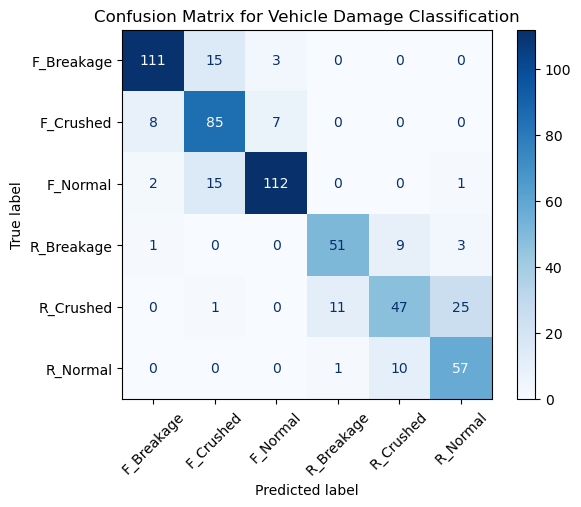

In [115]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from matplotlib import pyplot as plt

conf_matrix = confusion_matrix(all_labels, all_predicted, labels=np.arange(num_classes))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix for Vehicle Damage Classification")
plt.show()

In [117]:
torch.save(model.state_dict(), 'saved_model.pth')